In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.style('grade3',context='notebook', fscale=1.4, grid=True)
import seaborn as sns
sns.set_style("darkgrid")
jtplot.reset()
import sqlite3
%matplotlib inline

In [44]:
conn = sqlite3.connect('/Users/sominwadhwa/database.sqlite')
cur = conn.cursor()

In [45]:
countries = pd.read_sql_query("SELECT id,name from Country",conn)
matches = pd.read_sql_query("SELECT * from Match", conn)
leagues = pd.read_sql_query("SELECT * from League",conn)
teams = pd.read_sql_query("SELECT * from Team",conn)

In [46]:
major_league_countries = ['England','France','Germany','Italy','Spain']
countries = countries[countries.name.isin(major_league_countries)]
countries.head()

,id,name
1,1729,England
2,4769,France
3,7809,Germany
4,10257,Italy
9,21518,Spain


In [47]:
leagues = countries.merge(leagues,on='id', suffixes=('','_y'))
leagues.head()

,id,name,country_id,name_y
0,1729,England,1729,England Premier League
1,4769,France,4769,France Ligue 1
2,7809,Germany,7809,Germany 1. Bundesliga
3,10257,Italy,10257,Italy Serie A
4,21518,Spain,21518,Spain LIGA BBVA


In [48]:
matches = matches[matches.league_id.isin(leagues.id)]
matches = matches[['id', 'country_id' ,'league_id', 'season', 'stage', 'date','match_api_id', 'home_team_api_id', 'away_team_api_id','B365H', 'B365D' ,'B365A']]
matches.dropna(inplace=True)
matches.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,B365H,B365D,B365A
1728,1729,1729,1729,2008/2009,1,2008-08-17 00:00:00,489042,10260,10261,1.29,5.5,11.00
1729,1730,1729,1729,2008/2009,1,2008-08-16 00:00:00,489043,9825,8659,1.20,6.5,15.00
1730,1731,1729,1729,2008/2009,1,2008-08-16 00:00:00,489044,8472,8650,5.50,3.6,1.67
1731,1732,1729,1729,2008/2009,1,2008-08-16 00:00:00,489045,8654,8528,1.91,3.4,4.20
1732,1733,1729,1729,2008/2009,1,2008-08-17 00:00:00,489046,10252,8456,1.91,3.4,4.33


To see how 'truly' random was a match we need to calculate its 'entropy' function given the current bets we have on the basis of home/away game.

In [49]:
from scipy.stats import entropy
def match_entropy(match):
    odds = [match['B365H'], match['B365D'], match['B365A']]
    probs = [1/o for o in odds]
    norm = sum(probs)
    probs = [p/norm for p in probs]
    return entropy(probs)
matches['entropy'] = matches.apply(match_entropy,axis=1)
#Compute mean entropy in every league for every season:
entropy_season = matches.groupby(['season','league_id']).entropy.mean()
entropy_season.head(10)

season     league_id
2008/2009  1729         0.984556
           4769         1.026638
           7809         1.004276
           10257        1.002201
           21518        1.010859
2009/2010  1729         0.956496
           4769         1.013821
           7809         0.997925
           10257        1.006755
           21518        0.977810
Name: entropy, dtype: float64

In [50]:
entropy_season = entropy_season.reset_index().pivot(index = "season", columns="league_id", values="entropy")
entropy_season.columns =  [leagues[leagues.id==x].name.values[0] for x in entropy_season.columns]
entropy_season

,England,France,Germany,Italy,Spain
season,,,,,
2008/2009,0.984556,1.026638,1.004276,1.002201,1.010859
2009/2010,0.956496,1.013821,0.997925,1.006755,0.977810
2010/2011,0.983258,1.026236,1.016264,1.006029,0.975032
2011/2012,0.969593,1.024915,1.001298,1.003077,0.955339
2012/2013,0.981472,1.016116,0.993993,1.003565,0.970580
2013/2014,0.960473,1.004439,0.977500,0.992622,0.944218
2014/2015,0.980301,1.012495,0.985835,0.999100,0.933637
2015/2016,0.997819,1.013928,0.974657,0.985284,0.946813


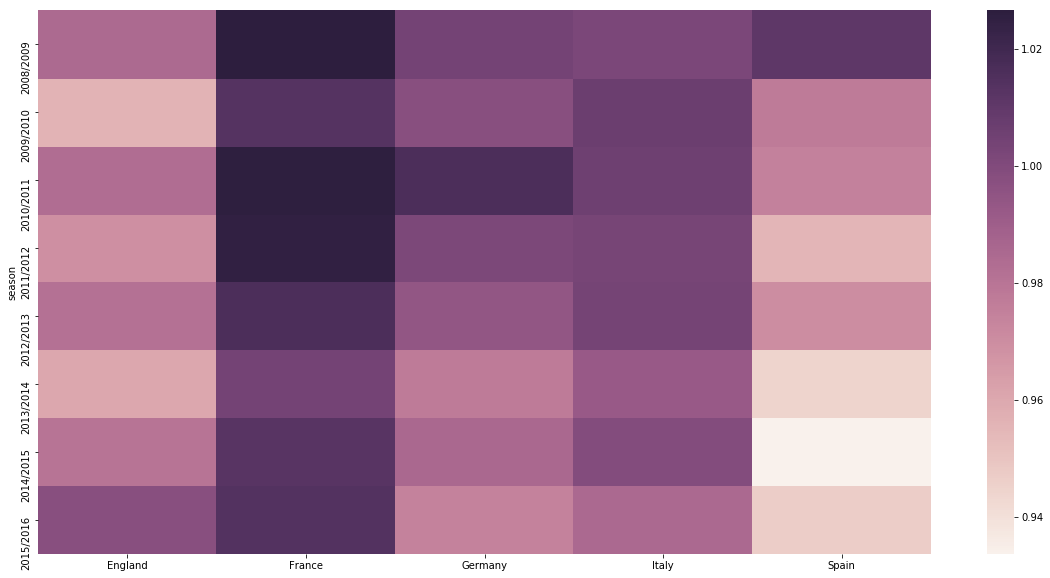

In [51]:
plt.figure(figsize=(20,10))
sns.heatmap(entropy_season)

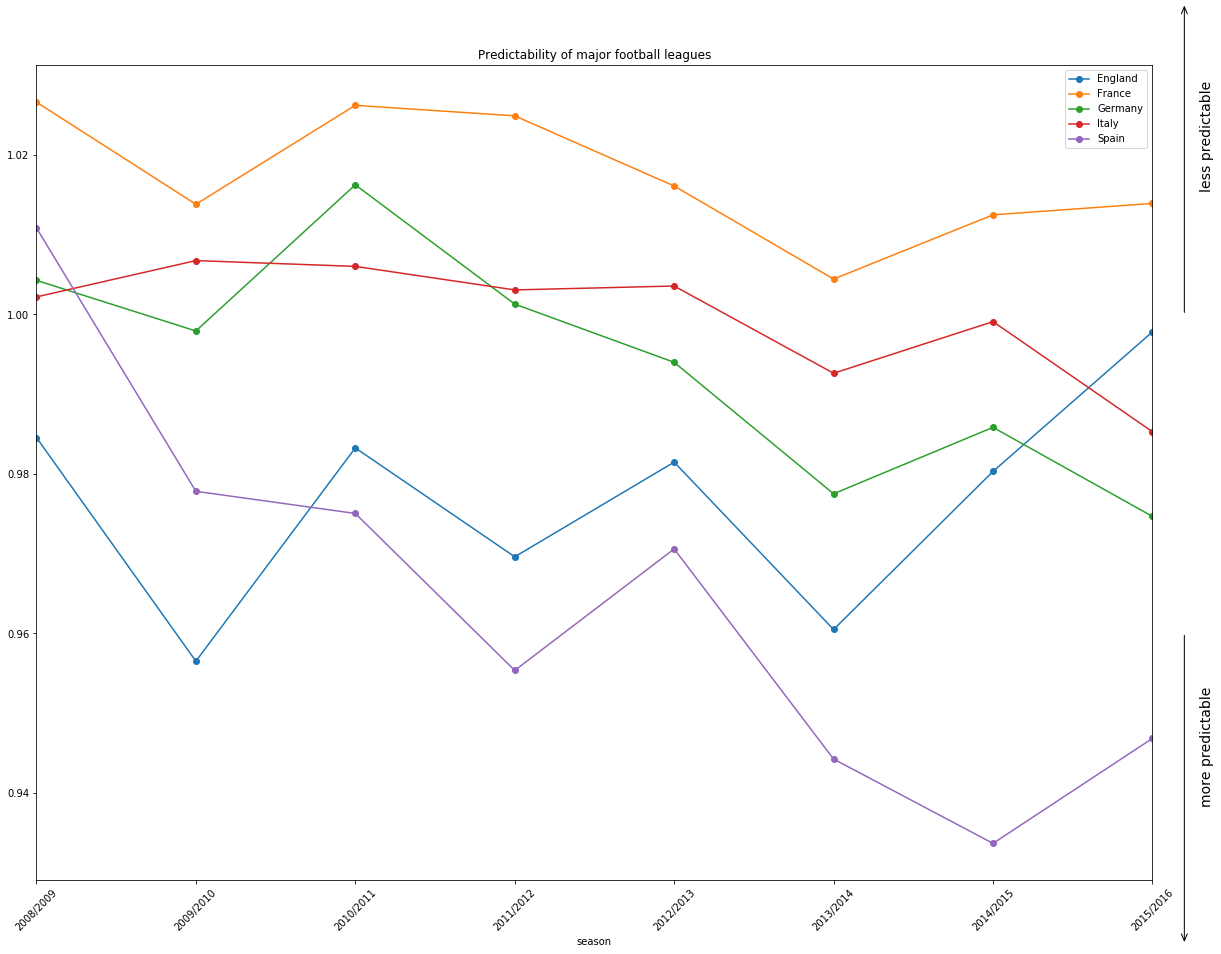

In [52]:
ax = entropy_season.plot(figsize=(20,15),marker='o')
plt.legend()
plt.title("Predictability of major football leagues")
ax.annotate('less predictable', xy=(7.3, 1.028), annotation_clip=False,fontsize=14,rotation='vertical')
ax.annotate('more predictable', xy=(7.3, 0.952), annotation_clip=False,fontsize=14,rotation='vertical')
ax.annotate('', xytext=(7.2, 1),xy=(7.2, 1.039),
            arrowprops=dict(facecolor='black',arrowstyle="->, head_length=.7, head_width=.3",linewidth=1), annotation_clip=False)

ax.annotate('', xytext=(7.2, 0.96),xy=(7.2, 0.921),
            arrowprops=dict(facecolor='black',arrowstyle="->, head_length=.7, head_width=.3",linewidth=1), annotation_clip=False)
plt.xticks(rotation=45)
plt.show()